# Imports

In [59]:
import time
import torch
import math
import random
import pathlib
import unidecode
import string
import scipy.signal
import numpy as np
import cgi
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm, trange
from PIL import Image

from scipy.signal import convolve2d
from scipy.signal import correlate2d
import zipfile, gzip, shutil, tarfile

# Helper functions

In [5]:
def download_data(fname, folder, url, tar):
    """
    Data downloading for OSF.

    Args:
    fname : str
      The name of the archive
    folder : str
      The name of the destination folder
    url : str
      The download url
    tar : boolean
      `tar=True` the archive is `fname`.tar.gz, `tar=False` is `fname`.zip
    Returns:
    Nothing.
    """

    if not os.path.exists(folder):
        print(f'\nDownloading {folder} dataset...')
        r = requests.get(url, allow_redirects=True)
        with open(fname, 'wb') as fh:
            fh.write(r.content)
        print(f'\nDownloading {folder} completed.')

        print('\nExtracting the files...\n')
        if not tar:
            with zipfile.ZipFile(fname, 'r') as fz:
                fz.extractall()
        else:
            with tarfile.open(fname) as ft:
                ft.extractall()
        # remove the archive
        os.remove(fname)

        # extract all .gz files
        foldername = folder + '/raw/'
        for filename in os.listdir(foldername):
            # remove the extension
            fname = filename.replace('.gz', '')
            # gunzip all files
            with gzip.open(foldername + filename, 'rb') as f_in:
                with open(foldername + fname, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
                    os.remove(foldername+filename)
    else:
        print(f'{folder} dataset has already been dowloaded.\n')


def check_shape_function(func, image_shape, kernel_shape):
    correct_shape = correlate2d(np.random.rand(*image_shape), np.random.rand(*kernel_shape), "valid").shape
    user_shape = func(image_shape, kernel_shape)
    if correct_shape != user_shape:
        print(f"❌ Your calculated output shape is not correct.")
    else:
        print(f"✅ Output for image_shape: {image_shape} and kernel_shape: {kernel_shape}, output_shape: {user_shape}, is correct.")


def check_conv_function(func, image, kernel):
    solution_user = func(image, kernel)
    solution_scipy = correlate2d(image, kernel, "valid")
    result_right = (solution_user == solution_scipy).all()
    if result_right:
        print("✅ The function calculated the convolution correctly.")
    else:
        print("❌ The function did not produce the right output.")
        print("For the input matrix:")
        print(image)
        print("and the kernel:")
        print(kernel)
        print("the function returned:")
        print(solution_user)
        print("the correct output would be:")
        print(solution_scipy)


def check_pooling_net(net, device='cpu'):
    x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
    output_x = net(x_img)
    output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

    right_output = [
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [9.309552, 1.6216984, 0.000000, 0.000000, 0.000000, 0.000000, 2.2708383,
      2.6654134, 1.2271233, 0.000000, 0.000000, 0.000000],
      [12.873457, 13.318945, 9.46229, 4.663746, 0.000000, 0.000000, 1.8889914,
      0.31068993, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 8.354934, 10.378724, 16.882853, 18.499334, 4.8546696, 0.000000,
      0.000000, 0.000000, 6.29296, 5.096506, 0.000000],
      [0.000000, 0.000000, 0.31068993, 5.7074604, 9.984148, 4.12916, 8.10037,
      7.667609, 0.000000, 0.000000, 1.2780352, 0.000000],
      [0.000000, 2.436305, 3.9764223, 0.000000, 0.000000, 0.000000, 12.98801,
      17.1756, 17.531992, 11.664275, 1.5453291, 0.000000],
      [4.2691708, 2.3217516, 0.000000, 0.000000, 1.3798618, 0.05612564, 0.000000,
      0.000000, 11.218788, 16.360992, 13.980816, 8.354935],
      [1.8126211, 0.000000, 0.000000, 2.9199777, 3.9382377, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 6.076582, 10.035061],
      [0.000000, 0.92164516, 4.434638, 0.7816348, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.83254766],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000]
  ]

    right_shape = (3, 12, 12)

    if output_x.shape != right_shape:
        print(f"❌ Your output does not have the right dimensions. Your output is {output_x.shape} the expected output is {right_shape}")
    elif (output_x[0] != right_output).all():
        print("❌ Your output is not right.")
    else:
        print("✅ Your network produced the correct output.")


# just returns accuracy on test data
def test(model, device, data_loader):
    model.eval()
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return f"{acc}%"

In [50]:
def display_image_from_greyscale_array(matrix, title):
    _matrix = matrix.astype(np.uint8)
    _img = Image.fromarray(_matrix, 'L')
    plt.figure(figsize=(3, 3))
    plt.imshow(_img, cmap='gray', vmin=0, vmax=255) # using 220 instead of 255 so the examples show up better
    plt.title(title)
    plt.axis('off')


def make_plots(original, actual_convolution, solution):
    display_image_from_greyscale_array(original, "Original Image")
    display_image_from_greyscale_array(actual_convolution, "Convolution result")
    display_image_from_greyscale_array(solution, "Your solution")


# code to plot loss and accuracy
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    #plt.show()
    
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return device

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)


# Turning a string into a tensor
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor


# Readable time elapsed
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    out = f"{m}min {s}sec"
    return out


def generate(decoder, prime_str='A', predict_len=100, temperature=0.8,
             device='cpu'):

    hidden = decoder.init_hidden(1)
    prime_input = char_tensor(prime_str).unsqueeze(0)

    hidden = hidden.to(device)
    prime_input = prime_input.to(device)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)

    inp = prime_input[:,-1]

    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char).unsqueeze(0)
        inp = inp.to(device)

    return predicted

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


# Convolutions and Edge Detection

At its core, convolution is just repeatedly multiplying a matrix, known as a _kernel_ or _filter_, with some other, larger matrix (in our case the pixels of an image). Consider the below image and kernel:

\begin{align}
\textbf{Image} &= 
\begin{bmatrix}0 & 200 & 200 \\0 & 0 & 200 \\ 0 & 0 & 0  
\end{bmatrix} \\ \\
\textbf{Kernel} &= 
\begin{bmatrix} \frac{1}{4} &\frac{1}{4} \\\frac{1}{4} & \frac{1}{4}
\end{bmatrix} 
\end{align}

Perform (by hand) the operations needed to convolve the kernel and image above. Afterwards enter your results in the "solution" section in the code below. Think about what this specific kernel is doing to the original image.

In [10]:
def conv_check():
    # Write the solution array and call the function to verify it!
    solution = np.array([
              [50, 150],
              [0, 50]
    ])

    original = np.array([
                       [0, 200, 200],
                       [0,   0, 200],
                       [0,   0,   0]
                       ])

    kernel = np.array([
                     [0.25, 0.25],
                     [0.25, 0.25]
                     ])

    actual_convolution = scipy.signal.correlate2d(original, kernel, mode="valid")

    if (solution == actual_convolution).all():
        print("✅ Your solution is correct!\n")
    else:
        print("❌ Your solution is incorrect.\n")

    return original, kernel, actual_convolution, solution

original, kernel, actual_convolution, solution = conv_check()
make_plots(original, actual_convolution, solution)

✅ Your solution is correct!



In [11]:
def calculate_output_shape(image_shape, kernel_shape):
    image_height, image_width = image_shape
    kernel_height, kernel_width = kernel_shape
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    return output_height, output_width

# here we check if your function works correcly by applying it to different image
# and kernel shapes
check_shape_function(calculate_output_shape, image_shape=(3, 3), kernel_shape=(2, 2))
check_shape_function(calculate_output_shape, image_shape=(3, 4), kernel_shape=(2, 3))
check_shape_function(calculate_output_shape, image_shape=(5, 5), kernel_shape=(5, 5))
check_shape_function(calculate_output_shape, image_shape=(10, 20), kernel_shape=(3, 2))
check_shape_function(calculate_output_shape, image_shape=(100, 200), kernel_shape=(40, 30))

✅ Output for image_shape: (3, 3) and kernel_shape: (2, 2), output_shape: (2, 2), is correct.
✅ Output for image_shape: (3, 4) and kernel_shape: (2, 3), output_shape: (2, 2), is correct.
✅ Output for image_shape: (5, 5) and kernel_shape: (5, 5), output_shape: (1, 1), is correct.
✅ Output for image_shape: (10, 20) and kernel_shape: (3, 2), output_shape: (8, 19), is correct.
✅ Output for image_shape: (100, 200) and kernel_shape: (40, 30), output_shape: (61, 171), is correct.


In [12]:
def convolution2d(image, kernel):
    """Convolves a 2D image matrix with a kernel matrix. Both are numpy arrays."""

    # get the height/width of the image, kernel, and output
    im_h, im_w = image.shape
    ker_h, ker_w = kernel.shape
    out_h = im_h - ker_h + 1
    out_w = im_w - ker_w + 1

    # create an empty matrix in which to store the output
    output = np.zeros((out_h, out_w))

    # iterate over the different positions at which to apply the kernel,
    #   storing the results in the output matrix
    for out_row in range(out_h):
        for out_col in range(out_w):
            # overlay the kernel on part of the image
            #   (multiply each element of the kernel with some element of the image, then sum)
            #   to determine the output of the matrix at a point
            current_product = 0
            for i in range(ker_h):
                for j in range(ker_w):
                    current_product += image[out_row + i, out_col + j] * kernel[i, j]

            output[out_row, out_col] = current_product

    return output

## Tests
# first, we test the parameters we used before in the manual-calculation example
image = np.array([[0,  200, 200], [0,   0,  200], [0,   0,   0]])
kernel = np.array([[0.25, 0.25], [0.25, 0.25]])
check_conv_function(convolution2d, image, kernel)

# next, we test with a different input and kernel (the numbers 1-9 and 1-4)
image = np.arange(9).reshape(3, 3)
kernel = np.arange(4).reshape(2, 2)
check_conv_function(convolution2d, image, kernel)

✅ The function calculated the convolution correctly.
✅ The function calculated the convolution correctly.


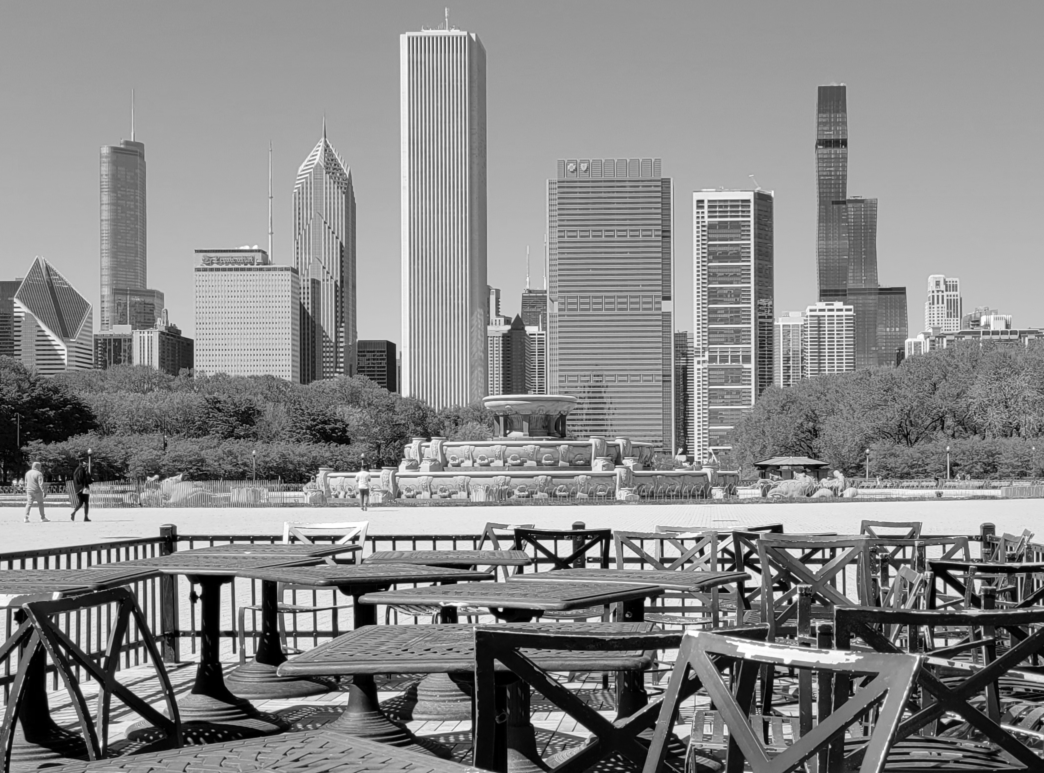

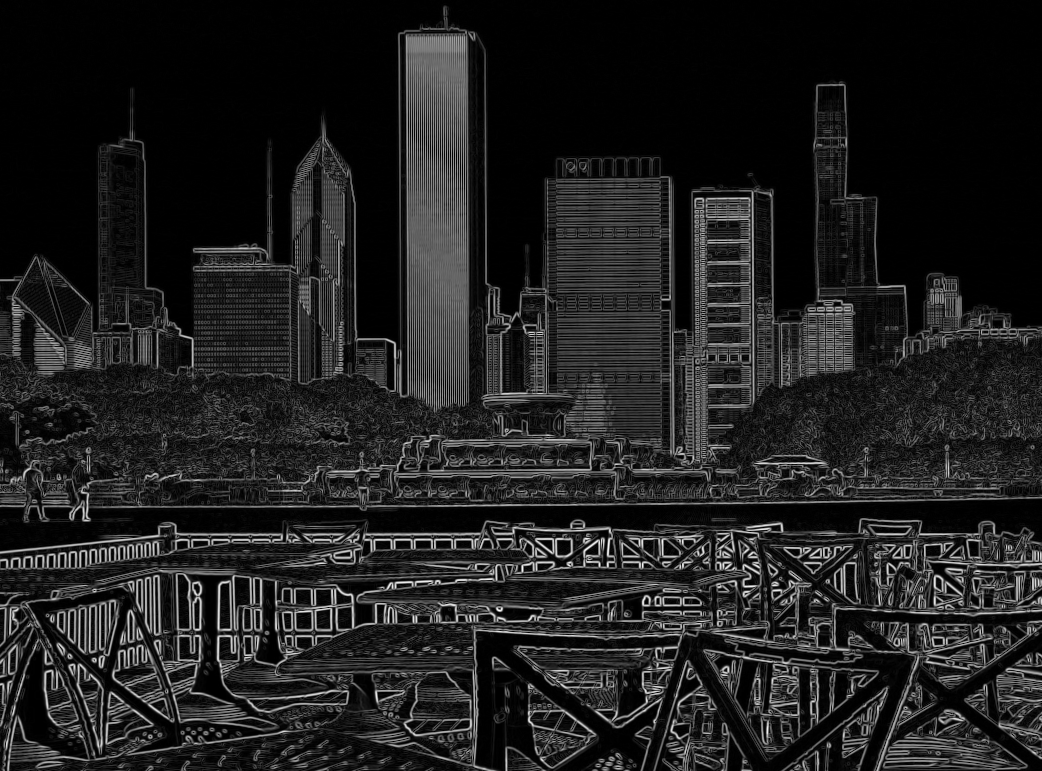

In [14]:
import requests, os

if not os.path.exists('images/'):
    os.mkdir('images/')

url = "https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D1_ConvnetsAndRecurrentNeuralNetworks/static/chicago_skyline_shrunk_v2.bmp"
r = requests.get(url, allow_redirects=True)
with open("images/chicago_skyline_shrunk_v2.bmp", 'wb') as fd:
    fd.write(r.content)
    
# Visualize the output of your function
with open("images/chicago_skyline_shrunk_v2.bmp", 'rb') as skyline_image_file:
    img_skyline_orig = Image.open(skyline_image_file)
    img_skyline_mat = np.asarray(img_skyline_orig)
    kernel_ver = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_hor = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).T
    img_processed_mat_ver = convolution2d(img_skyline_mat, kernel_ver)
    img_processed_mat_hor = convolution2d(img_skyline_mat, kernel_hor)
    img_processed_mat = np.sqrt(np.multiply(img_processed_mat_ver,
                                          img_processed_mat_ver) + \
                              np.multiply(img_processed_mat_hor,
                                          img_processed_mat_hor))

    img_processed_mat *= 255.0/img_processed_mat.max()
    img_processed_mat = img_processed_mat.astype(np.uint8)
    img_processed = Image.fromarray(img_processed_mat, 'L')
    display(img_skyline_orig)
    display(img_processed)

## CNN in PyTorch

In [15]:
class Net(nn.Module):
    """
    A convolutional neural network class.
    When an instance of it is constructed with a kernel, you can apply that instance
    to a matrix and it will convolve the kernel over that image.
    i.e. Net(kernel)(image)
    """
    def __init__(self, kernel=None, padding=0):
        super(Net, self).__init__()
        # Summary of the nn.conv2d parameters (you can also get this by hovering
        # over the method):
        # in_channels (int): Number of channels in the input image
        # out_channels (int): Number of channels produced by the convolution
        # kernel_size (int or tuple): Size of the convolving kernel
        # padding (int or tuple, optional): Zero-padding added to both sides of
        #     the input. Default: 0
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, \
                               padding=padding)

        # set up a default kernel if a default one isn't provided
        if kernel is not None:
            dim1, dim2 = kernel.shape[0], kernel.shape[1]
            kernel = kernel.reshape(1, 1, dim1, dim2)

            self.conv1.weight = torch.nn.Parameter(kernel)
            self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))

    def forward(self, x):
        x = self.conv1(x)
        return x

In [16]:
# Format a default 2x2 kernel of numbers from 0 through 3
kernel = torch.Tensor(np.arange(4).reshape(2, 2))
# Prepare the network with that default kernel
net = Net(kernel=kernel, padding=0).to(DEVICE)

# set up a 3x3 image matrix of numbers from 0 through 8
image = torch.Tensor(np.arange(9).reshape(3, 3))
image = image.reshape(1, 1, 3, 3).to(DEVICE) # BatchSizeXChannelsXHeightXWidth

print("Image:\n" + str(image))
print("Kernel:\n" + str(kernel))
output = net(image) # Apply the convolution
print("Output:\n" + str(output))

Image:
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])
Kernel:
tensor([[0., 1.],
        [2., 3.]])
Output:
tensor([[[[19., 25.],
          [37., 43.]]]], grad_fn=<ThnnConv2DBackward>)


In [17]:
print("Image (before padding):\n" + str(image))
print("Kernel:\n" + str(kernel))

# Prepare the network with the aforementioned default kernel, but this
# time with padding
net = Net(kernel=kernel, padding=1).to(DEVICE)
output = net(image)  # Apply the convolution onto the padded image
print("Output:\n" + str(output))

Image (before padding):
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])
Kernel:
tensor([[0., 1.],
        [2., 3.]])
Output:
tensor([[[[ 0.,  3.,  8.,  4.],
          [ 9., 19., 25., 10.],
          [21., 37., 43., 16.],
          [ 6.,  7.,  8.,  0.]]]], grad_fn=<ThnnConv2DBackward>)


## Padding and Edge Detection

[[1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]]


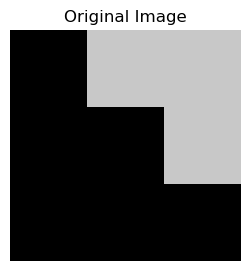

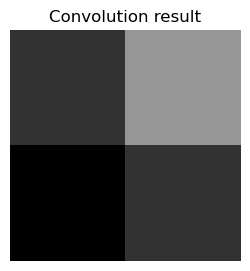

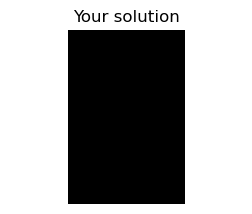

In [18]:
# Prepare an image that's basically just a vertical black stripe
X = np.ones((6, 8))
X[:, 2:6] = 0
print(X)
plt.imshow(X, cmap=plt.get_cmap('gray'))
plt.show()

[[ 0.  2.  0.  0.  0. -2.  0.]
 [ 0.  2.  0.  0.  0. -2.  0.]
 [ 0.  2.  0.  0.  0. -2.  0.]
 [ 0.  2.  0.  0.  0. -2.  0.]
 [ 0.  2.  0.  0.  0. -2.  0.]]


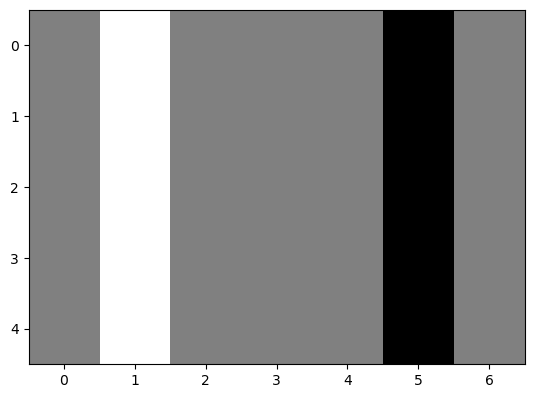

In [19]:
# Format the image that's basically just a vertical stripe
image = torch.from_numpy(X)
image = image.reshape(1, 1, 6, 8) # BatchSize X Channels X Height X Width

# Prepare a 2x2 kernel with 1s in the first column and -1s in the
# This exact kernel was discussed above!
kernel = torch.Tensor([[1.0, -1.0], [1.0, -1.0]])
net = Net(kernel=kernel)

# Apply the kernel to the image and prepare for display
processed_image = net(image.float())
processed_image = processed_image.reshape(5, 7).detach().numpy()
print(processed_image)
plt.imshow(processed_image, cmap=plt.get_cmap('gray'))
plt.show()

# Pooling and Subsampling

## Download EMNIST Dataset

In [21]:
# loading the dataset
def get_Xvs0_dataset(normalize=False, download=False):
    if normalize:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
            ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            ])

        emnist_train = datasets.EMNIST(root='.',
                                     split='letters',
                                     download=download,
                                     train=True,
                                     transform=transform)
        emnist_test = datasets.EMNIST(root='.',
                                    split='letters',
                                    download=download,
                                    train=False,
                                    transform=transform)

    # only want O (15) and X (24) labels
    train_idx = (emnist_train.targets == 15) | (emnist_train.targets == 24)
    emnist_train.targets = emnist_train.targets[train_idx]
    emnist_train.data = emnist_train.data[train_idx]

    # convert Xs predictions to 1, Os predictions to 0
    emnist_train.targets = (emnist_train.targets == 24).type(torch.int64)

    test_idx = (emnist_test.targets == 15) | (emnist_test.targets == 24)
    emnist_test.targets = emnist_test.targets[test_idx]
    emnist_test.data = emnist_test.data[test_idx]

    # convert Xs predictions to 1, Os predictions to 0
    emnist_test.targets = (emnist_test.targets == 24).type(torch.int64)

    return emnist_train, emnist_test



def get_data_loaders(train_dataset, test_dataset, batch_size=32, seed=0):

    g_seed = torch.Generator()
    g_seed.manual_seed(seed)

    train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
    test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

    return train_loader, test_loader

In [23]:
emnist_train, emnist_test = get_Xvs0_dataset(normalize=False, download=True)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

# index of an image in the dataset that corresponds to an X and O
x_img_idx = 4
o_img_idx = 15

0it [00:00, ?it/s]

Extracting ./EMNIST/raw/emnist.zip to ./EMNIST/raw
Processing byclass


/opt/miniconda3/envs/nma/lib/python3.9/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-x1rp5px8/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


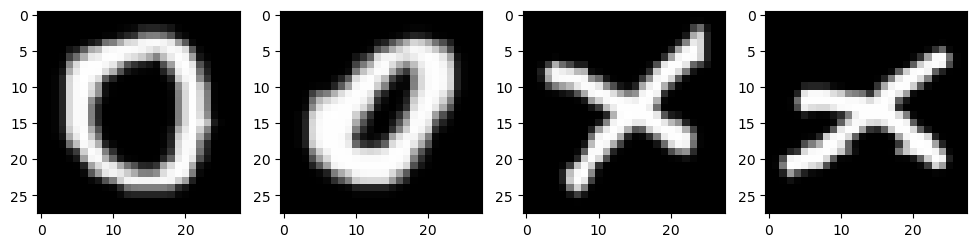

In [24]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))
ax1.imshow(emnist_train[0][0].reshape(28, 28), cmap='gray')
ax2.imshow(emnist_train[10][0].reshape(28, 28), cmap='gray')
ax3.imshow(emnist_train[4][0].reshape(28, 28), cmap='gray')
ax4.imshow(emnist_train[6][0].reshape(28, 28), cmap='gray')
plt.show()

## Multiple Filters

In [25]:
class Net2(nn.Module):
    def __init__(self, padding=0):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                               padding=padding)

        # first kernel - leading diagonal
        kernel_1 = torch.Tensor([[[ 1.,  1., -1., -1., -1.],
                                  [ 1.,  1.,  1., -1., -1.],
                                  [-1.,  1.,  1.,  1., -1.],
                                  [-1., -1.,  1.,  1.,  1.],
                                  [-1., -1., -1.,  1.,  1.]]])

        # second kernel - other diagonal
        kernel_2 = torch.Tensor([[[-1., -1., -1.,  1.,  1.],
                                  [-1., -1.,  1.,  1.,  1.],
                                  [-1.,  1.,  1.,  1., -1.],
                                  [ 1.,  1.,  1., -1., -1.],
                                  [ 1.,  1., -1., -1., -1.]]])

        # third kernel - checkerboard pattern
        kernel_3 = torch.Tensor([[[ 1.,  1., -1.,  1.,  1.],
                                  [ 1.,  1.,  1.,  1.,  1.],
                                  [-1.,  1.,  1.,  1., -1.],
                                  [ 1.,  1.,  1.,  1.,  1.],
                                  [ 1.,  1., -1.,  1.,  1.]]])


        # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
        multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

        self.conv1.weight = torch.nn.Parameter(multiple_kernels)
        # Negative bias
        self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

    def forward(self, x):
        x = self.conv1(x)
        return x

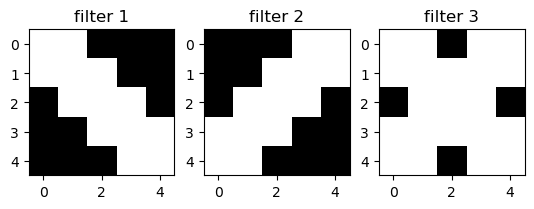

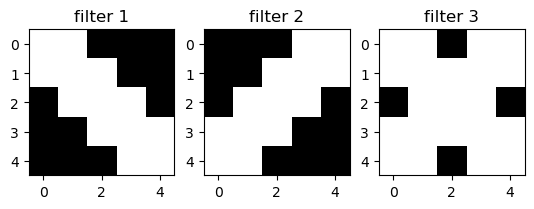

In [27]:
net2 = Net2().to(DEVICE)
fig, (ax11, ax12, ax13) = plt.subplots(1, 3)
# show the filters
ax11.set_title("filter 1")
ax11.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax12.set_title("filter 2")
ax12.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 3")
ax13.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")
plt.show()

In [28]:
net2 = Net2().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x = net2(x_img)
output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o = net2(o_img)
output_o = output_o.squeeze(dim=0).detach().cpu().numpy()

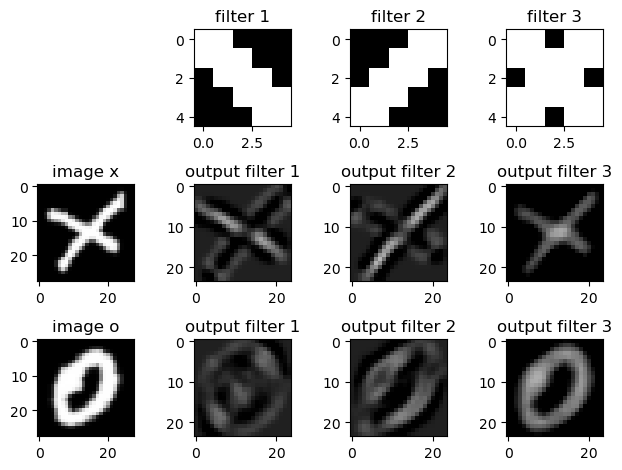

In [30]:
fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4)

# show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

# show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

## ReLU after Convolutions

Up until now we've talked about the convolution operation, which is linear. But the real strength of neural networks comes from the incorporation of non-linear functions.  Furthermore, in the real world, we often have learning problems where the relationship between the input and output is non-linear and complex. 

The ReLU (Rectified Linear Unit) introduces non-linearity into our model, allowing us to learn a more complex function that can better predict the class of an image.

The ReLU function is shown below.

<br>

<figure>
  <center><img src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D1_ConvnetsAndRecurrentNeuralNetworks/static/relu.png width=400px>
  <figcaption>The Rectified Linear Unit (ReLU) Activation Function<figcaption>
  </center>
</figure>

In [31]:
class Net3(nn.Module):
    def __init__(self, padding=0):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                               padding=padding)

        # first kernel - leading diagonal
        kernel_1 = torch.Tensor([[[ 1.,  1., -1., -1., -1.],
                                  [ 1.,  1.,  1., -1., -1.],
                                  [-1.,  1.,  1.,  1., -1.],
                                  [-1., -1.,  1.,  1.,  1.],
                                  [-1., -1., -1.,  1.,  1.]]])

        # second kernel - other diagonal
        kernel_2 = torch.Tensor([[[-1., -1., -1.,  1.,  1.],
                                  [-1., -1.,  1.,  1.,  1.],
                                  [-1.,  1.,  1.,  1., -1.],
                                  [ 1.,  1.,  1., -1., -1.],
                                  [ 1.,  1., -1., -1., -1.]]])

        # third kernel -checkerboard pattern
        kernel_3 = torch.Tensor([[[ 1.,  1., -1.,  1.,  1.],
                                  [ 1.,  1.,  1.,  1.,  1.],
                                  [-1.,  1.,  1.,  1., -1.],
                                  [ 1.,  1.,  1.,  1.,  1.],
                                  [ 1.,  1., -1.,  1.,  1.]]])


        # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
        multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

        self.conv1.weight = torch.nn.Parameter(multiple_kernels)
        # Negative bias
        self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        return x

In [32]:
net3 = Net3().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x_relu = net3(x_img)
output_x_relu = output_x_relu.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o_relu = net3(o_img)
output_o_relu = output_o_relu.squeeze(dim=0).detach().cpu().numpy()

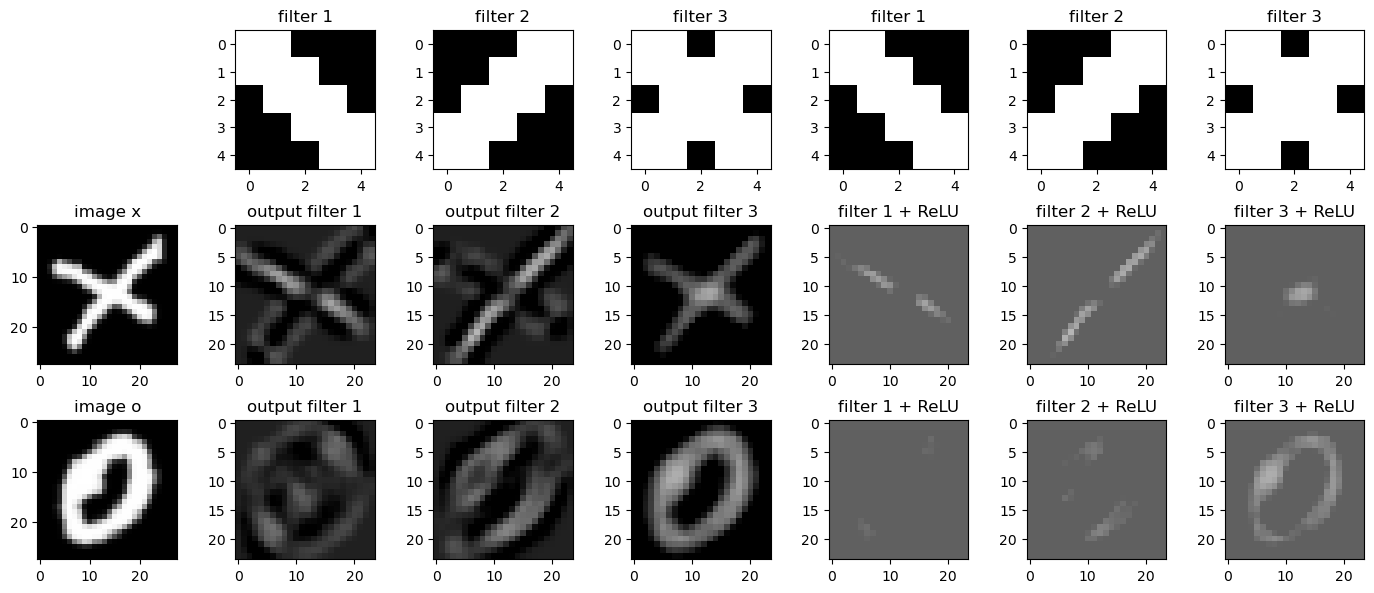

In [34]:
fig, ((ax11, ax12, ax13, ax14, ax15, ax16, ax17),
      (ax21, ax22, ax23, ax24, ax25, ax26, ax27),
      (ax31, ax32, ax33, ax34, ax35, ax36, ax37)) = plt.subplots(3, 4 + 3,
                                                                 figsize=(14, 6))
# show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net3.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net3.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net3.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

ax15.set_title("filter 1")
ax15.imshow(net3.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax16.set_title("filter 2")
ax16.imshow(net3.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax17.set_title("filter 3")
ax17.imshow(net3.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# show x and the filters applied to `x`
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

ax25.set_title("filter 1 + ReLU")
ax25.imshow(output_x_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax26.set_title("filter 2 + ReLU")
ax26.imshow(output_x_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax27.set_title("filter 3 + ReLU")
ax27.imshow(output_x_relu[2], cmap='gray', vmin=vmin, vmax=vmax)

# show o and the filters applied to `o`
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)

ax35.set_title("filter 1 + ReLU")
ax35.imshow(output_o_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax36.set_title("filter 2 + ReLU")
ax36.imshow(output_o_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax37.set_title("filter 3 + ReLU")
ax37.imshow(output_o_relu[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

## Pooling

Like convolutional layers, pooling layers have fixed-shape windows (pooling windows) that are systematically applied to the input.  As with filters, we can change the shape of the window and the size of the stride.  And, just like with filters, every time we apply a pooling operation we produce a single output. 

Pooling performs a kind of information compression that provides summary statistics for a _neighborhood_ of the input.
- In Maxpooling, we compute the maximum value of all pixels in the pooling window.
- In Avgpooling, we compute the average value of all pixels in the pooling window.

The example below shows the result of Maxpooling within the yellow pooling windows to create the red pooling output matrix.

<figure>
    <center><img src=https://developers.google.com/machine-learning/glossary/images/PoolingConvolution.svg?hl=fr width=400px>
    <figcaption>An Example of Pooling with a kernel size of 2</figcaption>
    </center>
</figure>

Pooling gives our network translational invariance by providing a summary of the values in each pooling window. Thus, A small change in the features of the underlying image won't make a huge difference to the output.

Note that, unlike a convolutional layer, the pooling layer contains no learned parameters! Pooling just computes a pre-determined summary of the input and passes that along.  This is in contrast to the convolutional layer, where there are filters to be learned. 


In [35]:
class Net4(nn.Module):
    def __init__(self, padding=0, stride=2):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                                padding=padding)

        # first kernel - leading diagonal
        kernel_1 = torch.Tensor([[[ 1.,  1., -1., -1., -1.],
                                  [ 1.,  1.,  1., -1., -1.],
                                  [-1.,  1.,  1.,  1., -1.],
                                  [-1., -1.,  1.,  1.,  1.],
                                  [-1., -1., -1.,  1.,  1.]]])

        # second kernel - other diagonal
        kernel_2 = torch.Tensor([[[-1., -1., -1.,  1.,  1.],
                                  [-1., -1.,  1.,  1.,  1.],
                                  [-1.,  1.,  1.,  1., -1.],
                                  [ 1.,  1.,  1., -1., -1.],
                                  [ 1.,  1., -1., -1., -1.]]])

        # third kernel -checkerboard pattern
        kernel_3 = torch.Tensor([[[ 1.,  1., -1.,  1.,  1.],
                                  [ 1.,  1.,  1.,  1.,  1.],
                                  [-1.,  1.,  1.,  1., -1.],
                                  [ 1.,  1.,  1.,  1.,  1.],
                                  [ 1.,  1., -1.,  1.,  1.]]])


        # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
        multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

        self.conv1.weight = torch.nn.Parameter(multiple_kernels)
        # Negative bias
        self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)  # pass through a max pool layer
        return x

## check if your implementation is correct
net4 = Net4().to(DEVICE)
check_pooling_net(net4, device=DEVICE)

✅ Your network produced the correct output.


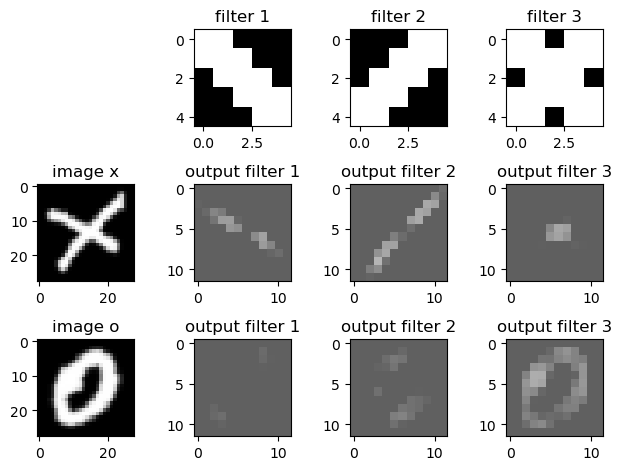

In [37]:
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x_pool = net4(x_img)
output_x_pool = output_x_pool.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o_pool = net4(o_img)
output_o_pool = output_o_pool.squeeze(dim=0).detach().cpu().numpy()

fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4)
# show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net4.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net4.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net4.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x_pool[2], cmap='gray', vmin=vmin, vmax=vmax)

# show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o_pool[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

# Putting it all together

Let's stack up all we have learnt. Create a CNN with the following structure. <br>
- Convolution `nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)`
- Convolution `nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)`
- Pool Layer `nn.MaxPool2d(kernel_size=2)`
- Fully Connected Layer `nn.Linear(in_features=9216, out_features=128)`
- Fully Connected layer `nn.Linear(in_features=128, out_features=2)`

Note: As discussed in the video, we would like to flatten the output from the Convolutional Layers before passing on the Linear layers, thereby converting an input of shape [BatchSize, Channels, Height, Width] to [BatchSize, Channels\\*Height\\*Width], which in this case would be from [32, 64, 12, 12] (output of second convolution layer) to [32, 64\*12\*12] = [32, 9216]. Recall that the input images have size [28, 28].

Hint: You could use `torch.flatten(x, 1)` in order to flatten the input at this stage. The 1 means it flattens dimensions starting with dimensions 1 in order to exclude the batch dimension from the flattening.

We should also stop to think about how we get the output of the pooling layer to be 12x12. It is because first, the two `Conv2d` with a `kernel_size=3` operations cause the image to be reduced to 26x26 and the second `Conv2d` reduces it to 24x24. Finally, the `MaxPool2d` operation reduces the output size by half to 12x12.

Also, don't forget the ReLUs (use e.g. `F.ReLU`)! No need to add a ReLU after the final fully connected layer.

In [48]:
class EMNIST_Net(nn.Module):
    def __init__(self):
        super(EMNIST_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 2)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# Recurrent Neural Networks

## Define a model

In [54]:
# RNN
# https://github.com/spro/char-rnn.pytorch
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
               model="gru", n_layers=1):
        """
        input_size: int
          Size of the input layer.
        hidden_size: int
          Size of the hidden layers.
        output_size: int
          Size of the output layer.
        model: string
          `model` can take the values "gru", "rnn", "lstm". Default is "gru".
        n_layers: int
          Number of layers
        """
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        elif self.model == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.reshape(1, batch_size, -1), hidden)
        output = self.decoder(output.reshape(batch_size, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (torch.zeros(self.n_layers, batch_size, self.hidden_size), torch.zeros(self.n_layers, batch_size, self.hidden_size))
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)

## Download language data

In [55]:
import requests

url = 'https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D1_ConvnetsAndRecurrentNeuralNetworks/static/twain.txt'
r = requests.get(url, stream=True)

with open('twain.txt', 'wb') as fd:
    fd.write(r.content)

## Train

In [56]:
# https://github.com/spro/char-rnn.pytorch
def random_training_set(file, file_len, chunk_len, batch_size,
                        device='cpu', seed=0):
    random.seed(seed)

    inp = torch.LongTensor(batch_size, chunk_len).to(device)
    target = torch.LongTensor(batch_size, chunk_len).to(device)

    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])

    return inp, target, chunk_len, batch_size, device


def train(decoder, criterion, inp, target, chunk_len, batch_size, device):
    hidden = decoder.init_hidden(batch_size)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:, c].to(device), hidden.to(device))
        loss += criterion(output.reshape(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()
    return loss.item() / chunk_len

In [57]:
# Reading and un-unicode-encoding data
all_characters = string.printable
n_characters = len(all_characters)

# load the text file
file, file_len = read_file('twain.txt')

# Hyperparams
batch_size = 50
chunk_len = 200
model = "rnn"  # other options: `lstm`, `gru`

n_layers = 2
hidden_size = 200
learning_rate = 0.01

# Define the model, optimizer, and the loss criterion
decoder = CharRNN(n_characters, hidden_size, n_characters,
                  model=model, n_layers=n_layers)
decoder.to(DEVICE)

decoder_optimizer = torch.optim.Adagrad(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [60]:
n_epochs = 1000   # initial was set to 2000

print_every = 50  # frequency of printing the outputs

start = time.time()
all_losses = []
loss_avg = 0

print(f"Training for {n_epochs} epochs...\n")
for epoch in tqdm(range(1, n_epochs + 1), position=0, leave=True):
    loss = train(decoder, criterion,
               *random_training_set(file, file_len, chunk_len, batch_size,
                                    device=DEVICE, seed=epoch))
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[{time_since(start)} {epoch/n_epochs * 100}%) {loss:.4f}]")
        print(f"{generate(decoder, prime_str='Wh', predict_len=150, device=DEVICE)}")

Training for 1000 epochs...



  0%|          | 0/1000 [00:00<?, ?it/s]

in 24.796844959259033sec 5.0%) 2.0056]
Whing
ofnits of the presald whitch--Cout fang the suppent. Huspert with ickouse. But his the was comest the whor aussartive to dows the So= firper he pp
in 48.84344983100891sec 10.0%) 1.8634]
Whing--

So to med plipped he didn't you bettarl of no shaditing that got heraghtect sosed then I ceners one all said, and the hen was ond
frop I was. I
in 11.652922868728638sec 15.0%) 1.8586]
Wh
gateresent, in a
some now and the kangentiled and got and of the came light useorth in nating not boun of she a don't he wish de able wound?"

"I the
in 33.89798593521118sec 20.0%) 1.8448]
Whous, bown it; bod a sow and the didn't the fornett!"

"No the larget to be rook if a she candnest a comeple." The seacling had so the retowey, and to 
in 57.66535186767578sec 25.0%) 1.8379]
Why then so them dim in stee forth he is steck amand the bark him to then or a ncomy aff-and do potch at come all peare a scople anyre a boke him, he go
in 20.089035987854004sec 30.0%) 1.7657]

In [61]:
print(f"{generate(decoder, prime_str='Wh', predict_len=100, device=DEVICE)}\n")

Why, stern the not its was divery didn't when they disperal and seeping a farts watch were dry. I was 

